In [2]:
import numpy as np
import matplotlib.pyplot as plt

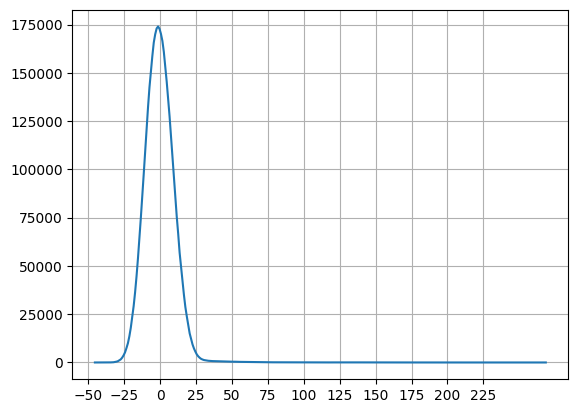

In [49]:
from histograms import make_histogram
master_dark = np.load('data/master_dark.npy')
img = np.load('data/images/image8.npy')

img -= master_dark

bin_centres, hist_data = make_histogram(img, -1)

plt.plot(bin_centres, hist_data)
plt.xticks(np.arange(-50,250,25))
plt.grid()
plt.show()

In [5]:
primary_threshold = 100
secondary_threshold = 20

primary_hits = np.where(img > primary_threshold, img, 0)
secondary_hits = np.where(np.logical_and(img > secondary_threshold, img<primary_threshold), img, 0)

primary_hit_locations = np.where(primary_hits > 0)
secondary_hit_locations = np.where(secondary_hits > 0)

[[0 0 2]
 [2 0 0]
 [0 2 0]]
[[0 1 0]
 [0 0 1]
 [1 0 0]]


## Determining hit values

Go through the image:
- First, looking for all primary hits
    - To get the value of a primary hit, seek out all pixels that are above $n\sigma$ of the pedestal noise around it (BFS) and sum them, along with the value of the primary hit
    - Record any secondary hits in this area. These are "used secondaries", and should not be considered later
    - The location of this hit should be the initial primary (for now)
- Now, go though all secondary hits
    - If a secondary has not already been used, then seek out all other pixels nearby that are bright enough (same as primaries), sum these
    - The location of this hit is the weighted average of all pixels considered

### Fitting the noise pedestal

In [9]:
from histograms import gaussian_model
from scipy.optimize import curve_fit

pedestal_params, _ = curve_fit(gaussian_model, bin_centres, hist_data, p0=[1e6, 0, 10])
pedestal_sigma = pedestal_params[2]
pedestal_params

array([ 1.74818675e+05, -1.01464805e+00,  9.56729796e+00])

In [3]:
from improved_spc import get_primary_hit_locations
from hit_detection import bfs


def get_primary_hits(img, primary_hits, secondary_hits, pedestal_sigma, n_sigma):
    primary_hit_locations = get_primary_hit_locations(primary_hits)

    final_hit_values = np.zeros(len(primary_hit_locations))
    final_hit_locations = []
    used_secondaries = np.zeros_like(secondary_hits)

    # pixels that are allowed for calculation
    valid_pixels = np.where(img > n_sigma * pedestal_sigma, img, 0)
    visited_valid = np.zeros_like(valid_pixels)

    for i, loc in enumerate(primary_hit_locations):
        loc = tuple(loc)

        # if the pixel has already been used, skip it
        if visited_valid[loc]:
            continue
        else:
            neighbours, visited_valid = bfs(loc, valid_pixels, visited_valid)

            # TODO: Fix bfs. Currently sometimes returns same pixel twice.
            neighbours = np.unique(np.array(neighbours), axis=0)
            # this will include the primary hit pixel
            final_hit_values[i] = np.sum(img[tuple(neighbours.T)])
            final_hit_locations.append(loc)

    used_secondaries = np.copy(visited_valid)
    used_secondaries = np.where(secondary_hits, used_secondaries, 0)

    return (
        final_hit_values[final_hit_values > 0],
        np.array(final_hit_locations),
        used_secondaries,
        visited_valid,
    )


test = np.array(
    [
        [1, 3, 1, 1, 0],
        [0, 0, 2, 3, 2],
        [2, 0, 0, 0, 0],
        [2, 0, 3, 2, 1],
        [0, 0, 1, 0, 0],
    ]
)

get_primary_hits(
    test,
    np.where(test > 2, test, 0),
    np.where(np.logical_and(test > 1, test < 3), test, 0),
    0.5,
    1,
)

(array([13.,  7.]),
 array([[0, 1],
        [3, 2]], dtype=int64),
 array([[0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]]),
 array([[1, 1, 1, 1, 0],
        [0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1],
        [0, 0, 1, 0, 0]]))

In [4]:
def get_secondary_hits(
    img, secondary_hits, used_secondaries, visited_valid, pedestal_sigma, n_sigma
):

    all_secondary_pixels = np.array(np.nonzero(secondary_hits)).transpose()

    final_hit_values = np.zeros(len(all_secondary_pixels))
    final_hit_locations = []

    # pixels that are allowed for calculation
    valid_pixels = np.where(img > n_sigma * pedestal_sigma, img, 0)

    for i, loc in enumerate(all_secondary_pixels):
        loc = tuple(loc)

        # if the pixel has already been used, skip it
        if used_secondaries[loc] or visited_valid[loc]:
            continue
        else:
            neighbours, visited_valid = bfs(loc, valid_pixels, visited_valid)

            if len(neighbours) < 2:
                continue

            neighbours = np.unique(np.array(neighbours), axis=0)
            # this will include the hit pixel
            final_hit_values[i] = np.sum(img[tuple(neighbours.T)])

            # final location is integer rounded weighted average of the neighbours
            final_hit_locations.append(
                np.rint(
                    np.average(neighbours, axis=0, weights=img[tuple(neighbours.T)])
                )
            )

    return final_hit_values[final_hit_values > 0], np.array(final_hit_locations)


test = np.array(
    [
        [1, 3, 1, 1, 0],
        [0, 0, 2, 3, 2],
        [2, 1, 0, 0, 0],
        [2, 0, 3, 2, 1],
        [0, 0, 1, 0, 0],
    ]
)

us, vv = get_primary_hits(
    test,
    np.where(test > 2, test, 0),
    np.where(np.logical_and(test > 1, test < 3), test, 0),
    0.5,
    1,
)[2:]
get_secondary_hits(
    test, np.where(np.logical_and(test > 1, test < 3), test, 0), us, vv, 0.5, 1
)

(array([5.]), array([[2., 0.]]))

## Testing this shit

In [5]:
from histograms import make_histogram
master_dark = np.load('data/master_dark.npy')
img = np.load('data/images/image8.npy')
img -= master_dark

bin_centres, hist_data = make_histogram(img, -1)

from histograms import gaussian_model
from scipy.optimize import curve_fit

pedestal_params, _ = curve_fit(gaussian_model, bin_centres, hist_data, p0=[1e6, 0, 10])
pedestal_sigma = pedestal_params[2]
pedestal_sigma

9.56729796114698

In [41]:
primary_threshold = 75
secondary_threshold = 30
n_sigma = 2
primary_hits = np.where(img > primary_threshold, img, 0)

secondary_hits = np.where(
    np.logical_and(img > secondary_threshold, img < primary_threshold), img, 0
)

primary_hit_values, primary_hit_locations, used_secondaries, visited_valid = (
    get_primary_hits(img, primary_hits, secondary_hits, pedestal_sigma, n_sigma)
)

secondary_hit_values, secondary_hit_locations = get_secondary_hits(
    img, secondary_hits, used_secondaries, visited_valid, pedestal_sigma, n_sigma
)

all_hit_values = np.concatenate((primary_hit_values, secondary_hit_values))


(0.0, 450.0)

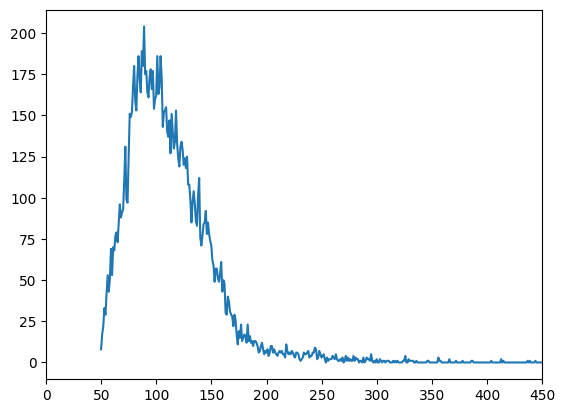

In [42]:
%matplotlib inline
from histograms import make_histogram

hits_bin_centres, hits_hist_data = make_histogram(all_hit_values, -1)

plt.plot(hits_bin_centres, hits_hist_data)
plt.xlim(0,450)

In [74]:
hit_locations = np.concatenate((primary_hit_locations, secondary_hit_locations))

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((y-.5, x-.5), 1,1, fill=False, linewidth=2, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect
%matplotlib qt
plt.imshow(img, cmap='jet')
for loc in hit_locations:
    highlight_cell(*loc, color='r')



: 

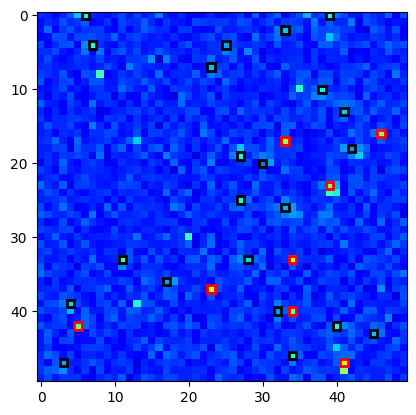

In [22]:
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((y-.5, x-.5), 1,1, fill=False, linewidth=2, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect
def test_region(img, rows, cols, primary_threshold, secondary_threshold, pedestal_sigma, n_sigma):
    img = img.copy()
    img = img[rows[0]:rows[1], cols[0]:cols[1]]

    primary_hits = np.where(img > primary_threshold, img, 0)

    secondary_hits = np.where(
        np.logical_and(img > secondary_threshold, img < primary_threshold), img, 0
    )

    primary_hit_values, primary_hit_locations, used_secondaries, visited_valid = (
        get_primary_hits(img, primary_hits, secondary_hits, pedestal_sigma, n_sigma)
    )

    secondary_hit_values, secondary_hit_locations = get_secondary_hits(
        img, secondary_hits, used_secondaries, visited_valid, pedestal_sigma, n_sigma
    )

    all_hit_values = np.concatenate((primary_hit_values, secondary_hit_values))
    all_hit_locations = np.concatenate((primary_hit_locations, secondary_hit_locations))

    plt.imshow(img, cmap='jet', vmin=-50, vmax=250)
    for loc in primary_hit_locations:
        highlight_cell(*loc, color='r')
    for loc in secondary_hit_locations:
        highlight_cell(*loc, color='black')
    
%matplotlib inline
        
test_region(img, [1200, 1250], [1390,1440], 80, 30, 9.56729796114698, 2)


## Conclusions

- Histogram is not very sensitive to primary threshold (varied between 60-100, not much difference)
    - although, if set too high (like >=100), we see a second peak in the historgram within the main peak, located at the primary threshold. So, should probably keep low enough to avoid this

- Secondary threshold should not go much below 30, otherwise we get a peak at the low end of the histogram, probably from the pedestal noise. Optimal value seems to be between 30 and 50

- 2-photon peak not really possible to see. Probably too few double hits detected to see it. (Looking at the image, double hits seem to be pretty rare)